In [1]:
import numpy as np
from PIL import Image
import sys 
from scipy import signal
import pyVHR as vhr
import pickle
import torch
import matplotlib.pyplot as plt

2022-10-25 14:01:05.573855: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
PATCH_SIZE = 16
EMBED_DIM = PATCH_SIZE * PATCH_SIZE * 3
NUM_PATCHES = 100
IMG_SIZE = PATCH_SIZE * NUM_PATCHES
HEADS = 12
BLOCKS = 12
BATCH = 300
LENGTH = 160

In [3]:
vhr.plot.VisualizeParams.renderer = 'notebook'  # or 'notebook'
    
#SET DATASET

dataset_name = 'pure'           
video_DIR = '/var/datasets/VHR1/PURE'  
BVP_DIR = '/var/datasets/VHR1/PURE'    

dataset = vhr.datasets.datasetFactory(dataset_name, videodataDIR=video_DIR, BVPdataDIR=BVP_DIR)
allvideo = dataset.videoFilenames

def getVideo(idx):
    wsize = 8          
    video_idx = idx     
    fname = dataset.getSigFilename(video_idx)
    sigGT = dataset.readSigfile(fname)
    #train_bvp = [sigGT.data[0][i] for i in range(0,len(sigGT.data[0])-1,2)]
    bpmGT, timesGT = sigGT.getBPM(wsize)
    videoFileName = dataset.getVideoFilename(video_idx)
    fps = vhr.extraction.get_fps(videoFileName)
    print(videoFileName,fps)
    #vhr.plot.display_video(videoFileName)
    return videoFileName, fps, sigGT, bpmGT, timesGT

/var/datasets/VHR1/PURE


/var/datasets/VHR1/PURE/06-05/06-05.avi 30.0
3894


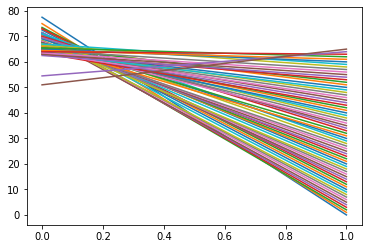

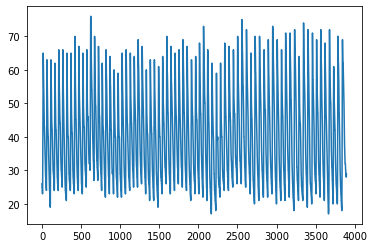

(array([77.5, 75. , 71.5, 71. , 70.5, 70. , 70.5, 70.5, 70. , 71.5, 72.5,
       73. , 73.5, 73. , 71.5, 70. , 70. , 69.5, 68.5, 70. , 71. , 70. ,
       69.5, 69.5, 68. , 68. , 68. , 67.5, 69.5, 71. , 69. , 66.5, 67.5,
       70. , 69.5, 67.5, 66. , 66.5, 67. , 66. , 65. , 65.5, 65. , 63.5,
       64. , 64.5, 63.5, 64. , 64.5, 63.5, 64. , 66. , 65.5, 63. , 62.5,
       63. , 63.5, 64.5, 66.5, 67. , 65. , 64.5, 65.5, 64. , 54.5, 51. ]), array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65.]))


In [7]:
_,fps,sigGT,bpmGT,timesGT=getVideo(0)
print(len(sigGT.data[0]))
plt.plot(sigGT.getBPM())
plt.show()
plt.plot(sigGT.data[0])
plt.show()
print(sigGT.getBPM())

In [5]:
#SKIN EXTRACTION AND VISUALIZATION
def patches_extraction(videFileName, fps):
    sig_extractor = vhr.extraction.SignalProcessing()
    sig_extractor.display_cuda_device()
    sig_extractor.choose_cuda_device(0)
    
    sig_extractor.set_skin_extractor(vhr.extraction.SkinExtractionConvexHull('GPU'))
    seconds = 0
    sig_extractor.set_total_frames(seconds*fps)

    vhr.extraction.SkinProcessingParams.RGB_LOW_TH = 2
    vhr.extraction.SkinProcessingParams.RGB_HIGH_TH = 254
    vhr.extraction.SignalProcessingParams.RGB_LOW_TH = 2
    vhr.extraction.SignalProcessingParams.RGB_HIGH_TH = 254

    sig_extractor.set_visualize_skin_and_landmarks(
          visualize_skin=True, 
          visualize_landmarks=True, 
          visualize_landmarks_number=True, 
          visualize_patch=True)

    landmarks = [2, 3, 4, 5, 6, 8, 9, 10, 18, 21, 32, 35, 36, 43, 46, 47, 48, 50, 54, \
             58, 67, 68, 69, 71, 92, 93, 101, 103, 104, 108, 109, 116, 117, \
             118, 123, 132, 134, 135, 138, 139, 142, 148, 149, 150, 151, 152, 182, 187, 188, 193, 197, 201, 205, 206, 207, \
             210, 211, 212, 216, 234, 248, 251, 262, 265, 266, 273, 277, 278, 280, \
             284, 288, 297, 299, 322, 323, 330, 332, 333, 337, 338, 345, \
             346, 361, 363, 364, 367, 368, 371, 377, 379, 411, 412, 417, 421, 425, 426, 427, 430, 432, 436]

    
    sig_extractor.set_landmarks(landmarks)

    #PATCHES EXTRACTION
    sig_extractor.set_square_patches_side(PATCH_SIZE + 0.0)
    patch_sig = sig_extractor.extract_patches(videoFileName, "squares", "mean")
    visualize_patches_coll = sig_extractor.get_visualize_patches()
    patches = sig_extractor.patches

    return patches

In [6]:
def weaver(patches, sigGT):
    train_bvp = signal.resample(sigGT.data[0], len(patches)).astype(int)

    #for each frame concatenate patches in one image
    webs = []

    for f_p in patches:
        if len(f_p)==100:
            tmp=np.concatenate(f_p[0:10])
            for i in range(10,len(f_p),10):
                r=np.concatenate(f_p[i:i+10])
                tmp=np.concatenate((tmp,r),axis=1)
            if webs==[]:
                webs = torch.unsqueeze(torch.as_tensor(tmp),0)
            else:
                webs = torch.cat((webs,torch.unsqueeze(torch.as_tensor(tmp),0)))

    #inputs = torch.as_tensor(inputs)
    plt.imshow(webs[0])
    plt.show()
    return webs, train_bvp

In [7]:
def write_webs(video_idx,webs,train_bvp):
    with open('/var/datasets/VIPL-HR-V1_webs/'+str(video_idx)+'-WEBS-'+str(PATCH_SIZE), 'wb') as f:
        pickle.dump((webs,train_bvp), f, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
videoFileName, fps, sigGT = getVideo(0)
patches = patches_extraction(videoFileName, fps)

# CUDA devices:  1
# device number  0 :  Tesla V100S-PCIE-32GB


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


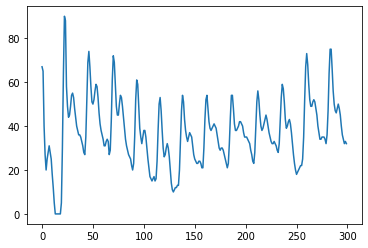

In [14]:
plt.plot(train_bvp[0:300])
plt.show()

In [13]:
print("total ", len(allvideo))
for idx in range(15,50):
    print("INDEX ",idx)
    videoFileName, fps, sigGT = getVideo(idx)
    print(f'Video processed name: {videoFileName}\nVideo frame rate:     {fps}')
    #patches = patches_extraction(videoFileName, fps)
    #print("patches: ", len(patches), len(patches[0]), patches[0][0].shape)
    #webs, train_bvp = weaver(patches, sigGT)
    #write_webs(idx, webs, train_bvp)

total  59
INDEX  15
/var/datasets/VHR1/PURE/01-03/01-03.avi 30.0
Video processed name: /var/datasets/VHR1/PURE/01-03/01-03.avi
Video frame rate:     30.0
INDEX  16
/var/datasets/VHR1/PURE/07-04/07-04.avi 30.0
Video processed name: /var/datasets/VHR1/PURE/07-04/07-04.avi
Video frame rate:     30.0
INDEX  17
/var/datasets/VHR1/PURE/05-05/05-05.avi 30.0
Video processed name: /var/datasets/VHR1/PURE/05-05/05-05.avi
Video frame rate:     30.0
INDEX  18
/var/datasets/VHR1/PURE/08-02/08-02.avi 30.0
Video processed name: /var/datasets/VHR1/PURE/08-02/08-02.avi
Video frame rate:     30.0
INDEX  19
/var/datasets/VHR1/PURE/05-02/05-02.avi 30.0
Video processed name: /var/datasets/VHR1/PURE/05-02/05-02.avi
Video frame rate:     30.0
INDEX  20
/var/datasets/VHR1/PURE/10-02/10-02.avi 30.0
Video processed name: /var/datasets/VHR1/PURE/10-02/10-02.avi
Video frame rate:     30.0
INDEX  21
/var/datasets/VHR1/PURE/06-01/06-01.avi 30.0
Video processed name: /var/datasets/VHR1/PURE/06-01/06-01.avi
Video fra

KeyboardInterrupt: 

In [8]:
a =[]
for idx in range(0,50):
    with open('/var/datasets/PURE_webs/'+str(idx)+'-WEBS-'+str(PATCH_SIZE), 'rb') as f:
        (webs,train_bvp) = pickle.load(f)
        a.append(len(webs))
        
print(min(a))

1950
